In [5]:
import matplotlib.pyplot as plt
import numpy as np 
from scipy.interpolate import RegularGridInterpolator

def integrate_particles(positions, concentrations, velocity_field, X, Y, dt, num_steps, L, phase_field, gamma):
    num_particles = len(positions)
    positions_over_time,  concentrations_over_time = np.zeros((num_steps+1, num_particles, 2)), np.zeros((num_steps+1, num_particles, 1))
    positions_over_time[0] = positions
    concentrations_over_time[0] = concentrations
    psiy, psix = -1*diff_wrt_y(velocity_field), diff_wrt_x(velocity_field)
    phix, phiy = diff_wrt_x(phase_field), diff_wrt_y(phase_field)
    interpsiy, interphix, interpsix, interphiy = interpolate(psiy), interpolate(phix), interpolate(psix), interpolate(phiy)
    #t_span = (0, num_steps * dt)
    #t_eval = [i * dt for i in range(num_steps+1)]
    t = [i*dt for i in range(num_steps+1)]
    psiyx, psixy = diff_wrt_x(psiy), diff_wrt_y(psix)
    phixx, phiyy = diff_wrt_x(phix), diff_wrt_y(phiy)
    interpsiyx, interphixx, interpsixy, interphiyy = interpolate(psiyx), interpolate(phixx), interpolate(psixy), interpolate(phiyy)
    a = [interpsiy, interphix, interpsix, interphiy, interpsiyx, interphixx, interpsixy, interphiyy]
    answer = new_vector_rk4(fun, t, polynomial_u, polynomial_v, positions_over_time, polynomial_du, polynomial_dv, concentrations_over_time, num_particles, a)
    return answer

def polynomial_u(coords, a):
    interpsiy, interphix = a[0], a[1]
    return (1-gamma)*interpsiy(coords)+gamma*interphix(coords)

def polynomial_v(coords, a):
    interpsix, interphiy = a[2], a[3]
    return (1-gamma)*interpsix(coords)+gamma*interphiy(coords)

def polynomial_du(coords, a):
    interpsiyx, interphixx = a[4], a[5]
    return (1-gamma)*interpsiyx(coords)+gamma*interphixx(coords)

def polynomial_dv(coords, a):
    interpsixy, interphiyy = a[6], a[7]
    return (1-gamma)*interpsixy(coords)+gamma*interphiyy(coords)

def diff_wrt_y(original_matrix): 
    nt, nx, ny = original_matrix.shape
    umatrix = np.copy(original_matrix)
    for i in range(nt):
        umatrix[i] = np.gradient(original_matrix[i], axis=1) 
    return umatrix

def diff_wrt_x(original_matrix):
    vmatrix = np.copy(original_matrix)
    nt, nx, ny = original_matrix.shape
    for i in range(nt):
        vmatrix[i] = np.gradient(original_matrix[i], axis=0) 
    return vmatrix

def interpolate(umatrix):

    t = umatrix.shape[0]
    time = [i for i in range(t)]
    interpolator = RegularGridInterpolator((time, X, Y), umatrix, method = "cubic")
    return interpolator

def new_vector_rk4(f, t, polynomial_u, polynomial_v, positions_over_time, polynomial_du, polynomial_dv, concentrations_over_time, num_particles, a):
    n = len(t)
    y = np.concatenate((positions_over_time, concentrations_over_time), axis=2)

    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(t[i], y[i], polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        k2 = f(t[i] + 0.5*h, y[i] + 0.5*h*k1, polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        k3 = f(t[i] + 0.5*h, y[i] + 0.5*h*k2, polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        k4 = f(t[i+1], y[i] + h*k3, polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a)
        y[i+1] = y[i] + (h/6)*(k1 + 2*k2 + 2*k3 + k4)
    return np.mod(y, 2*L)

def fun(t, y, polynomial_u, polynomial_v, polynomial_du, polynomial_dv, num_particles, a):
    #interpsiy, interphix, interpsix, interphiy, interpsiyx, interphixx, interpsixy, interphiyy = a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7]
    xlist, ylist, conclist = [i % (2*L) for i in y[:, 0]], [i % (2*L) for i in y[:, 1]], [i % (2*L)  for i in y[:, 2]] 
    timecoords = t*np.ones(num_particles)
    coords = [[x, y, z] for x, y, z in zip(timecoords, xlist, ylist)]
    dxdt, dydt = polynomial_u(coords, a), polynomial_v(coords, a)
    dxdt, dydt = np.array(dxdt).reshape(-1, 1), np.array(dydt).reshape(-1, 1)
    dudx, dvdy = polynomial_du(coords, a), polynomial_dv(coords, a)
    column = np.array(dvdy+dudx).reshape(-1, 1)
    c = np.array(conclist).reshape(-1, 1)
    dcdt = -1*c*(column)
    result = np.concatenate((dxdt, dydt), axis=1)
    result = np.concatenate((result, dcdt), axis=1)
    return result




In [13]:
positions = np.random.rand(6, 2)/5
concentrations = np.ones((6, 1))
#print(concentrations)
X = [0, 1, 2, 3, 4, 5, 6]
Y = X
dt=0.001
num_steps=10
L=100
velocity_field = np.arange(20*7*7).reshape((20, 7, 7))
#print(velocity_field)
phase_field = np.zeros(20*7*7).reshape((20, 7, 7))
gamma = 0
path = integrate_particles(positions, concentrations, velocity_field, X, Y, dt, num_steps, L, phase_field, gamma)

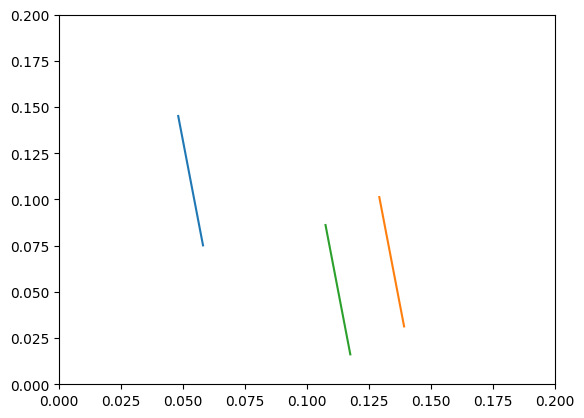

In [11]:
xcoords = [path[i][0][0] for i in range(num_steps+1)]
ycoords = [path[i][0][1] for i in range(num_steps+1)]
xcoords2 = [path[i][1][0] for i in range(num_steps+1)]
ycoords2 = [path[i][1][1] for i in range(num_steps+1)]
xcoords3 = [path[i][2][0] for i in range(num_steps+1)]
ycoords3 = [path[i][2][1] for i in range(num_steps+1)]

plt.plot(xcoords, ycoords)
plt.plot(xcoords2, ycoords2)
plt.plot(xcoords3, ycoords3)
plt.xlim(0, 0.2)
plt.ylim(0, 0.2)

plt.show()